##  House Price Prediction - Linear Regression from Scratch

This notebook builds a linear regression model to predict house prices using the Housing dataset. It involves end-to-end steps from data cleaning to evaluation.

### 1. Data Preprocessing
### 2. Feature Engineering
### 3. Linear Regression Training
### 4. Model Evaluation
### 5. Data Visualization
The notebook demonstrates a clean, step-by-step implementation of linear regression using only NumPy, Pandas and Matplotlib.


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Loading train.csv and test.csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Combining them for processing
train['source'] = 'train'
test['source'] = 'test'
data_all = pd.concat([train, test], ignore_index=True)



### Data Preprocessing

- **Missing Values:** Dropped columns with many nulls, filled numerical columns with mean and categorical with mode.
- **Encoding:** Applied one-hot encoding to selected categorical features.
- **Outliers:** Removed extreme outliers from training data (`GrLivArea > 4000` and `SalePrice < 300000`).
- **Splitting:** Separated `data_all` back into `train_data` and `test_data`, dropping helper columns.

This prepares the data for modeling.


In [ ]:
missing = data_all.isnull().sum()
missing = missing[missing>0].sort_values(ascending=False)
print(missing)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
KitchenQual        1
GarageArea         1
SaleType           1
dtype: int64


In [ ]:
# Drop columns with > 1000 null values
data_all.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# Fill missing values
num_cols = data_all.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data_all.select_dtypes(include=['object']).columns

# Numerical - mean
for col in num_cols:
    data_all[col] = data_all[col].fillna(data_all[col].mean())

# Categorical - mode
for col in cat_cols:
    data_all[col] = data_all[col].fillna(data_all[col].mode()[0])



In [ ]:
# Add selected categorical features

cat_features = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageType',
                'MSZoning', 'SaleCondition', 'Foundation', 'BldgType', 'HouseStyle', 'HeatingQC']
data_all = pd.get_dummies(data_all, columns=cat_features, drop_first=True)

# Remove outliers (GrLivArea > 4000 & SalePrice < 300000) in TRAIN only
data_all = data_all[~((data_all['source'] == 'train') &
                      (data_all['GrLivArea'] > 4000) &
                      (data_all['SalePrice'] < 300000))]

# Split back into train and test
train_data = data_all[data_all['source'] == 'train'].copy()
test_data = data_all[data_all['source'] == 'test'].copy()

# Drop helper column
train_data.drop(columns=['source'], inplace=True)
test_data.drop(columns=['source', 'SalePrice'], inplace=True)

###  Feature Engineering

- Extracted and normalized the target variable (`SalePrice`) using z-score.
- Dropped ID and target columns to create feature sets.
- Removed any remaining non-numeric columns.
- Normalized features using training set statistics.
- Converted DataFrames to NumPy arrays and added bias term (column of 1s) for modeling.


In [ ]:
# Target
y = train_data['SalePrice'].values.reshape(-1, 1)
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# Features (drop ID & target)
drop_cols = ['Id', 'SalePrice']
X_train = train_data.drop(columns=drop_cols)
X_test = test_data.drop(columns=['Id'])

# Drop non-numeric columns remaining
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

# Save column names for debug
feature_names = X_train.columns.tolist()

# Normalize using train stats
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Final matrices
X_train_np = X_train.values.astype('float64')
X_test_np = X_test.values.astype('float64')
X_train_b = np.c_[np.ones((X_train_np.shape[0], 1)), X_train_np]
X_test_b = np.c_[np.ones((X_test_np.shape[0], 1)), X_test_np]

### Linear Regression with Gradient Descent

- Implemented cost function and gradient descent to train a linear regression model on normalized data.


In [ ]:
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X @ theta
    cost = (1 / (2 * m)) * np.sum((predictions - y)**2)
    return cost

def gradient_descent_verbose(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []

    for i in range(iterations):
        predictions = X @ theta
        error = predictions - y
        gradient = (1 / m) * (X.T @ error)
        theta -= alpha * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)

        # Print RMSE every 100 iterations
        if i % 100 == 0 or i == iterations - 1:
            rmse = np.sqrt(2 * cost)
            print(f"Iteration {i}: RMSE = {rmse:.2f}")

    return theta, cost_history


### Model Evaluation
- Tracked cost over iterations and printed RMSE every 100 steps.
- Made predictions on training data and inverse-transformed the target.
- Calculated evaluation metrics: **MSE**, **RMSE**, and **MAPE**.
- Displayed top 10 numeric features most correlated with `SalePrice`.

In [ ]:
theta = np.zeros((X_train_b.shape[1], 1))
alpha = 0.01
iterations = 1000

theta_final, cost_history = gradient_descent_verbose(X_train_b, y_norm, theta, alpha, iterations)




Iteration 0: RMSE = 0.92
Iteration 100: RMSE = 0.33
Iteration 200: RMSE = 0.31
Iteration 300: RMSE = 0.31
Iteration 400: RMSE = 0.30
Iteration 500: RMSE = 0.30
Iteration 600: RMSE = 0.30
Iteration 700: RMSE = 0.29
Iteration 800: RMSE = 0.29
Iteration 900: RMSE = 0.29
Iteration 999: RMSE = 0.29


In [ ]:
# Predict on training data
y_pred_norm = X_train_b @ theta_final
y_pred = y_pred_norm * y_std + y_mean  # inverse normalization
y_actual = y  # already original

# Manual Metrics
mse = np.mean((y_actual - y_pred) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print("\n Final Evaluation on Training Data:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



🔍 Final Evaluation on Training Data:
Mean Squared Error (MSE): 538432953.91
Root Mean Squared Error (RMSE): 23204.16
Mean Absolute Percentage Error (MAPE): 9.18%


In [ ]:
# Fix: compute correlations on numeric features only
correlations = train_data.select_dtypes(include=['int64', 'float64']).corr()['SalePrice'].sort_values(ascending=False)
print(correlations.head(10))


SalePrice       1.000000
OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
YearBuilt       0.523608
Name: SalePrice, dtype: float64


###  Visualizing Top Features vs SalePrice

- Plotted scatter plots for top correlated features (`OverallQual`, `GrLivArea`, `GarageCars`, `YearBuilt`) against `SalePrice`.
- Each feature is shown in a separate figure for clarity.
- Helps visually assess linear relationships between individual features and the target variable.


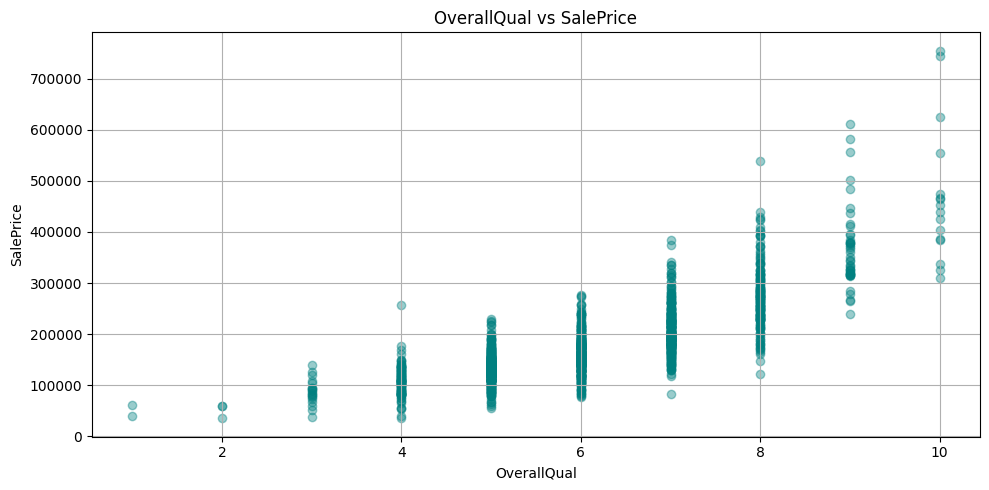

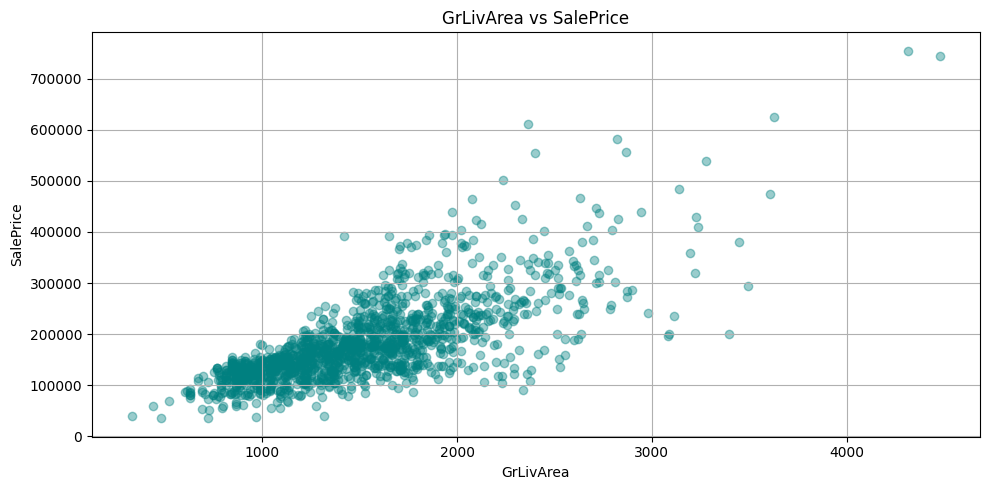

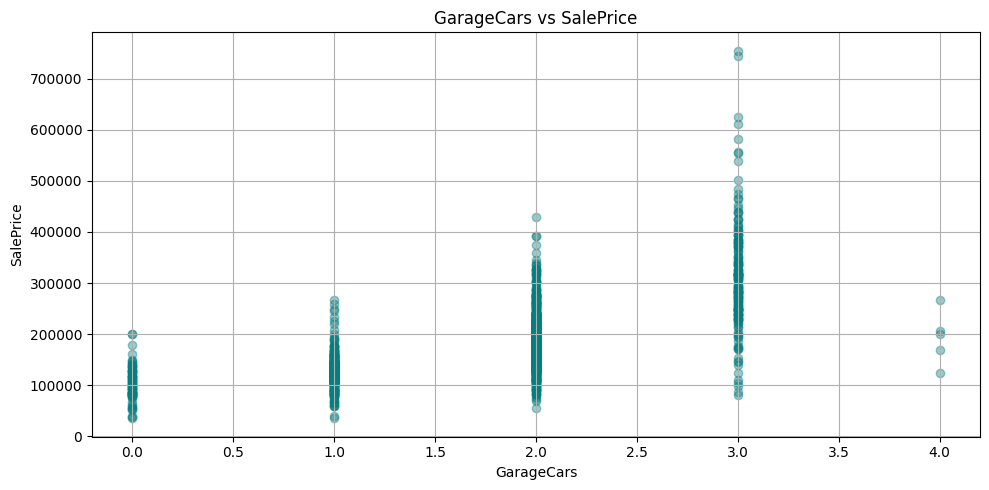

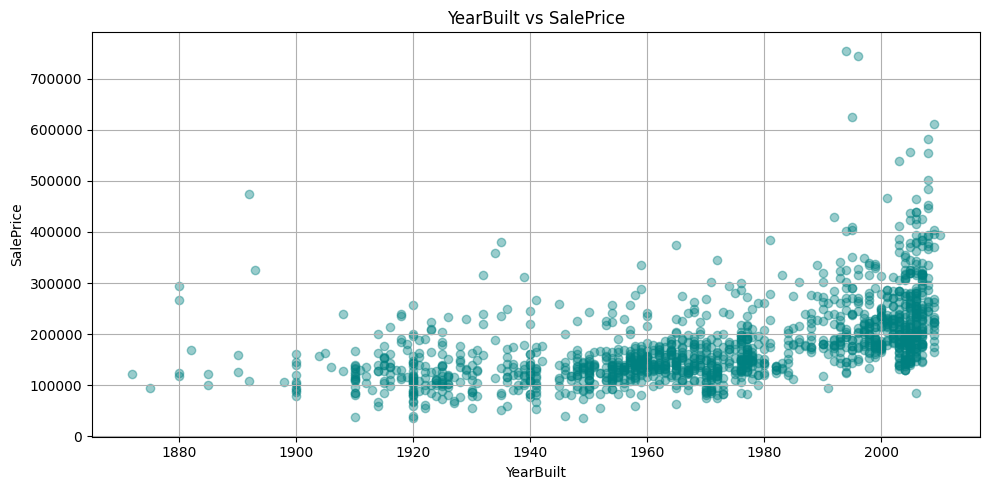

In [ ]:
import matplotlib.pyplot as plt

# List of top correlated features to plot
features_to_plot = ['OverallQual', 'GrLivArea',  'GarageCars', 'YearBuilt']

# Number of subplots per figure
plots_per_figure = 1

# Loop through features and create separate figures
for i in range(0, len(features_to_plot), plots_per_figure):
    plt.figure(figsize=(10, 5))
    for j in range(plots_per_figure):
        if i + j < len(features_to_plot):
            feature = features_to_plot[i + j]
            plt.subplot(1, plots_per_figure, j + 1)
            plt.scatter(train_data[feature], train_data['SalePrice'], alpha=0.4, color='teal')
            plt.xlabel(feature)
            plt.ylabel("SalePrice")
            plt.title(f"{feature} vs SalePrice")
            plt.grid(True)
    plt.tight_layout()
    plt.show()
